In [1]:
import pygplates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

print(pygplates.__version__)

from gprm import ReconstructionModel, SubductionConvergence, PointDistributionOnSphere
from gprm.datasets import Reconstructions, Seafloor
from gprm.utils.create_gpml import gpml2gdf

import pygmt
import xrspatial as xrs
from gprm.utils.deformation import topological_reconstruction, raster_topological_reconstruction

from ptt import ridge_spreading_rate
from scipy.ndimage import uniform_filter1d

import matplotlib as mpl
mpl.rc('font',family='Helvetica')
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2


0.36.0


In [2]:
df_AllTimes = pd.read_csv('../data/Crustal_Production_M2021_0_600_5.csv')

min_time = 0
max_time = 600
time_step = 5

In [3]:
atlantic_plate_pairs = [[201,701], [101, 714], [701,101], [201, 714], [714, 201], [101,102], [102,301], [101,301], 
                        [101,304], [101,317], [802,101], [818,815],[201,802]]
indian_plate_pairs = [[701,802],[801,802], [511,801], [511,802], [701,501], [701,702], [501,802], [704,501], [702,802], [774,801], 
                      [511,709], [503,701], [673,7250], [664,676], [702,501], [501,801]]
pacific_plate_pairs = [[901,902], [901,911], [901,804], [901,910], [901,909], [909,902], [901,903], [901,924], [909,911], 
                       [911,804], [911,802], [802,901], [922,911], [923,911], [699,608], [659,608], [870,823], [829,836], 
                       [830,847], [646,677], [0,0], [901,982], [814,901], [901,926], [902,926],
                       [926,919],[902,908],[982,983],[983,981],[983,901],[901,919],[990,926],[902,919],[919,908],
                       [908,901], [908,982], [908,984], [919,983],[903,918], [986,982], [986,983], [986,987], [984,908], [903,918],
                       [980441,8013], [9804411,98044], [9804411,98043], [9804411,4101], [9804411,10191], [4101,10191], [501,98043],
                       [98044,98043], [101,8013], [980441,4101], [980441,302], [980441,101]]

#panthalassa_plate_pairs = [[926,919],[902,908],[982,983],[983,981],[983,901],[901,919],[990,926],[902,919],[919,908],
#                           [908,901], [908,982], [908,984], [919,983],[903,918], [986,982], [986,983], [986,987], [984,908], [903,918]]

tethys_plate_pairs = [[9006,701], [604,701], [701,601], [701,602]]
tethys2_plate_pairs = [[506,701], [606,701], [308,521], [598,9], [544,545], [530,534], [786,740]]
tethys3_plate_pairs = [[895,501], [895,801], [529,528], [787],[789], [780,781], [780,678]]

rheic_plate_pairs = [[9019,701], [302,701], [5802,701], [302,9019], [302,5802], [602,501], [108,302], [184,714], [580,701],
                     [22013,101], [22032,101], [302,101], [401,101], [108,701], [1007,1018], [101,22601], [184,185],
                     [701,101], [401,4101], [315,701],
                     [401,302], [401,404], [404,302], [302,404]] # Aegir

asian_plate_pairs = [[401,430], [9013,9014], [601,602], [5801,580], [602,604], [601,501], [602,701], [601,701],
                     [457,459], [457,460], [457,505], [457,580], [457,701], [456,580], [456,602], [602,801], [459,460], [459,501], [451,580], [451,602], [466,701],
                     [451,4511], [451,456], [580,4661], [601,801], [801,6026]]
                     #[501,602]]

'''
{(101.0, 184.0),
 (101.0, 401.0),
 (101.0, 701.0),
 (101.0, 22601.0),
 (184.0, 185.0),
 (302.0, 404.0),
 (302.0, 580.0),
 (302.0, 701.0),
 (315.0, 701.0),
 (580.0, 701.0),
 (801.0, 6026.0),
 (902.0, 919.0),
 (902.0, 926.0),
 (919.0, 926.0),
 (1007.0, 1018.0)}
''' 

preserved_crust_distance_threshold = 200.

#atlantic_plate_pairs = []
#indian_plate_pairs = []
#pacific_plate_pairs = [(701, 101), (101, 301), (646, 677), 
#                       (901, 970), (701, 802), (701, 201), (101, 224), (201, 101), (911, 804), (673, 7250), 
#                       (802, 201), (317, 101), (911, 901), (503, 709), (901, 804), (0, 0), (699, 608), (802, 911), 
#                       (818, 815), (801, 802), (923, 804)]

def get_crustal_production_time_series(spreading_df, min_time, max_time, time_step, plate_pairs=None, preserved=None):
    
    crustal_production_time_series = []
    for reconstruction_time in np.arange(min_time, max_time + time_step, time_step):

        subset = spreading_df[spreading_df['reconstruction_time']==reconstruction_time]
        
        if preserved:
            subset = subset[subset['distance_to_preserved_crust']<preserved]
            
        
        if not plate_pairs:
            crustal_production_time_series.append(0.001 * np.sum(subset['arc_length'] * subset['spreading_rate']* np.cos(np.radians(subset['spreading_obliq']))))

        else:
            #plate_pairs = set(plate_pairs)
            crustal_production = 0
            for plate_pair in plate_pairs:
                subset_pp = subset[(subset.right_plate_id.isin(plate_pair)) & (subset.left_plate_id.isin(plate_pair))]
                crustal_production += np.sum(0.001 * subset_pp['arc_length'] * subset_pp['spreading_rate'] * np.cos(np.radians(subset['spreading_obliq'])))
            crustal_production_time_series.append(crustal_production)
            
    return crustal_production_time_series

        
global_crustal_production = get_crustal_production_time_series(df_AllTimes, min_time, max_time, time_step)
global_crustal_production_preserved = get_crustal_production_time_series(df_AllTimes, min_time, max_time, time_step, preserved=preserved_crust_distance_threshold)
atlantic_crustal_production = get_crustal_production_time_series(df_AllTimes, min_time, max_time, time_step, atlantic_plate_pairs, preserved=preserved_crust_distance_threshold)
indian_crustal_production = get_crustal_production_time_series(df_AllTimes, min_time, max_time, time_step, indian_plate_pairs, preserved=preserved_crust_distance_threshold)
pacific_crustal_production = get_crustal_production_time_series(df_AllTimes, min_time, max_time, time_step, pacific_plate_pairs, preserved=preserved_crust_distance_threshold)
#panthalassa_crustal_production = get_crustal_production_time_series(df_AllTimes, min_time, max_time, time_step, panthalassa_plate_pairs)
panthalassa_crustal_production = get_crustal_production_time_series(df_AllTimes, min_time, max_time, time_step, pacific_plate_pairs)
panthalassa_crustal_production = [pan-pac for pan, pac in zip(panthalassa_crustal_production, pacific_crustal_production)]

tethys_crustal_production = get_crustal_production_time_series(df_AllTimes, min_time, max_time, time_step, tethys_plate_pairs)
tethys2_crustal_production = get_crustal_production_time_series(df_AllTimes, min_time, max_time, time_step, tethys2_plate_pairs)
tethys3_crustal_production = get_crustal_production_time_series(df_AllTimes, min_time, max_time, time_step, tethys3_plate_pairs)
rheic_crustal_production = get_crustal_production_time_series(df_AllTimes, min_time, max_time, time_step, rheic_plate_pairs)
asian_crustal_production = get_crustal_production_time_series(df_AllTimes, min_time, max_time, time_step, asian_plate_pairs)

other_crustal_production_preserved = [a-b-c-d for a, b, c, d in zip(global_crustal_production_preserved, 
                                                          atlantic_crustal_production,
                                                          indian_crustal_production,
                                                          pacific_crustal_production,)]



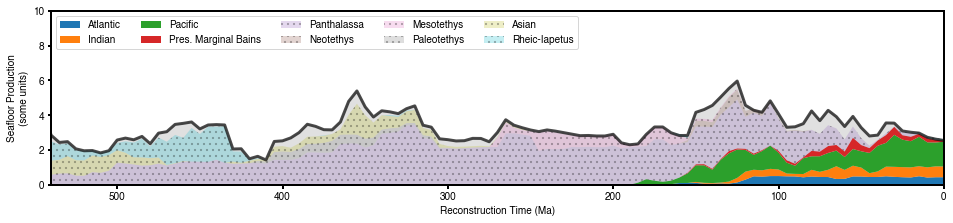

In [4]:
plt.figure(figsize=(16,3.2))
plt.plot(np.arange(min_time, max_time + time_step, time_step), global_crustal_production, color='black',linewidth=3,alpha=0.7)
#plt.plot(np.arange(min_time, max_time + time_step, time_step), global_crustal_production_preserved, color='red',linewidth=3,alpha=0.7)

plt.fill_between(np.arange(min_time, max_time + time_step, time_step), global_crustal_production, color='lightgrey',alpha=0.7)

stacks = plt.stackplot(np.arange(min_time, max_time + time_step, time_step), 
                       np.vstack((atlantic_crustal_production, 
                                  indian_crustal_production, 
                                  pacific_crustal_production, 
                                  other_crustal_production_preserved,
                                  panthalassa_crustal_production,
                                  tethys3_crustal_production,
                                  tethys2_crustal_production,
                                  tethys_crustal_production,
                                  asian_crustal_production,
                                  rheic_crustal_production)),
                      labels=['Atlantic', 'Indian', 'Pacific', 'Pres. Marginal Bains', 'Panthalassa','Neotethys','Mesotethys','Paleotethys','Asian','Rheic-Iapetus'])

#hatches=["\\", "//","+"]
for stack in stacks[4:]:
    stack.set_hatch('..')
    #stacks[3].set_edgecolor('red')
    #stack.set_facecolor('white')
    stack.set_alpha(0.25)
    stack.set_edgecolor('black')
    stack.set_linewidth(0)

tmp = stacks[3]
#np.vstack((atlantic_crustal_production, indian_crustal_production, pacific_crustal_production))
plt.ylim(0,10)
plt.xlim(540,0)
plt.xlabel('Reconstruction Time (Ma)')
plt.ylabel('Seafloor Production\n(some units)')
plt.legend(loc='upper left', ncol=5)
#plt.grid()
plt.show()


In [5]:
reconstruction_time = 465
subset = df_AllTimes[df_AllTimes['reconstruction_time']==reconstruction_time]

plist = []
for i,row in subset.iterrows():
    plist.append(tuple(np.sort([row.left_plate_id,row.right_plate_id])))
    
set(plist)


{(101.0, 184.0),
 (101.0, 401.0),
 (101.0, 701.0),
 (101.0, 22601.0),
 (184.0, 185.0),
 (302.0, 404.0),
 (302.0, 580.0),
 (302.0, 701.0),
 (315.0, 701.0),
 (580.0, 701.0),
 (801.0, 6026.0),
 (902.0, 919.0),
 (902.0, 926.0),
 (919.0, 926.0),
 (1007.0, 1018.0)}

(600.0, 0.0)

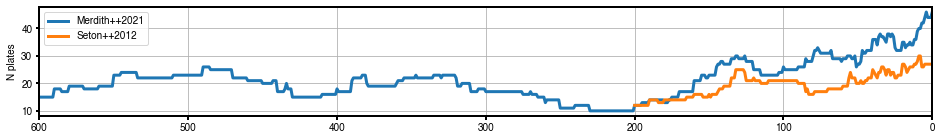

In [6]:
M2021 = Reconstructions.fetch_Merdith2021()
S2012 = Reconstructions.fetch_Seton2012()

normalized_earth_area = 4 * np.pi

def nplates_series(time_series, reconstruction_model, area_threshold_frac=None):
    num_plates = []
    for reconstruction_time in time_series:
        res = reconstruction_model.plate_snapshot(reconstruction_time)
        if area_threshold_frac:
            num_plates.append(np.sum(np.greater_equal(res.plate_areas, area_threshold_frac*pygplates.Earth.mean_radius_in_kms**2)))
        else:
            num_plates.append(len(res.plate_areas))
        #print(np.sum(np.greater_equal(res.plate_areas, area_threshold_frac*pygplates.Earth.mean_radius_in_kms**2)), len(res.plate_areas))
    return num_plates
    #break

M2021_time_series = np.arange(0, 601, 1)
M2021_nplates = nplates_series(M2021_time_series, M2021)
S2012_time_series = np.arange(0, 201, 1)
S2012_nplates = nplates_series(S2012_time_series, S2012)

plt.figure(figsize=(16,2))
plt.plot(M2021_time_series, M2021_nplates, label='Merdith++2021', linewidth=3)
#plt.plot(time_series, nplates_series(time_series, M2021, area_threshold_frac=0.02), label='Merdith++2021 filtered', linewidth=2, linestyle='-',zorder=0)
plt.plot(S2012_time_series, S2012_nplates, label='Seton++2012', linewidth=3)
plt.ylabel('N plates')
plt.grid()
plt.legend()
plt.xlim(600,0)

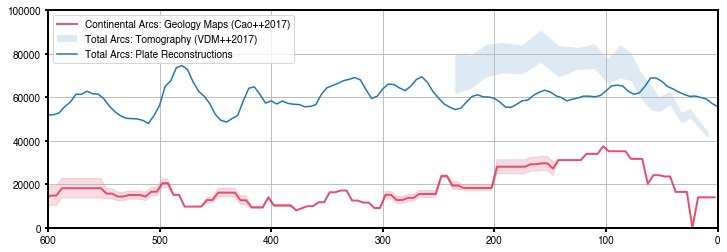

In [7]:
N = 3

subduction_kinematics_AllTimes = pd.read_csv('../data/SubductionFlux_M2021_0_600_5.csv')
#time_bins = np.arange(0,601,5)+5/2.

vdm = pd.read_csv('../data/VDM_length_errors.csv')

continental_arc_lengths = []
continental_arc_lengths2 = []
no_collision_arc_lengths = []
total_arc_lengths = []

plot_time_series = np.arange(min_time, max_time + time_step, time_step)

for reconstruction_time in plot_time_series:
    
    tsubset = subduction_kinematics_AllTimes[reconstruction_time==subduction_kinematics_AllTimes.time]
    no_collisions = tsubset[(tsubset.distance_to_ocean<200.)]
    subset = tsubset[(tsubset.distance_to_continent<100.) & (tsubset.distance_to_ocean<400.)]
    subset = subset[subset.nearest_continent_plateid!=subset.subducting_plate]
    #subset2 = tsubset[(tsubset.distance_to_continent<100.) & (tsubset.distance_to_ocean<100.)]
    subset2 = tsubset[(tsubset.distance_to_continent<200.) & (tsubset.distance_to_ocean<400.)]
    subset2 = subset2[subset2.nearest_continent_plateid!=subset2.subducting_plate]

                                    
    continental_arc_lengths.append((subset.arc_length.sum()*2*np.pi*pygplates.Earth.mean_radius_in_kms)/360.)
    continental_arc_lengths2.append((subset2.arc_length.sum()*2*np.pi*pygplates.Earth.mean_radius_in_kms)/360.)
    total_arc_lengths.append((tsubset.arc_length.sum()*2*np.pi*pygplates.Earth.mean_radius_in_kms)/360.)
    no_collision_arc_lengths.append((no_collisions.arc_length.sum()*2*np.pi*pygplates.Earth.mean_radius_in_kms)/360.)


plt.figure(figsize=(12,4))
    
df_cao = pd.read_excel('../data/Cao++_mmc2_ed.xlsx')

ctime_step = 5.
ctime_max = 750.
ctime_bins = np.arange(0,ctime_max,ctime_step)+ctime_step/2.

summed_length_av = []
summed_length_min = []
summed_length_max = []

for time in ctime_bins:
    #print time,time+time_step/2.
    subset = df_cao.where((df_cao['Onset time [Ma]']>=time) & (df_cao['Termination time [Ma]']<time))
    #print subset
    summed_length_av.append(np.nansum(subset['ave/pref. length [km]']))
    summed_length_min.append(np.nansum(subset['min length [km]']))
    summed_length_max.append(np.nansum(subset['max length [km]']))

plt.plot(ctime_bins, summed_length_av, linewidth=2, color='crimson', alpha=0.7, label='Continental Arcs: Geology Maps (Cao++2017)')

#plt.fill_between(plot_time_series, 
#                 uniform_filter1d(continental_arc_lengths, size=N), 
#                 uniform_filter1d(continental_arc_lengths2, size=N), color='magenta', alpha=0.15, label='Continental Arcs: Plate Reconstructions')

plt.fill_between(vdm.time, vdm.length-vdm['length error'], vdm.length+vdm['length error']+vdm['imaging error'],alpha=0.15, label='Total Arcs: Tomography (VDM++2017)')


plt.plot(plot_time_series,
         uniform_filter1d(no_collision_arc_lengths, size=N), label='Total Arcs: Plate Reconstructions')

plt.fill_between(ctime_bins, summed_length_min, summed_length_max,color='crimson',alpha=0.15)

plt.ylim(0,100000)
plt.xlim(600,0)
plt.grid()
plt.legend(loc='upper left')
plt.show()


Text(0, 0.5, 'Latitude')

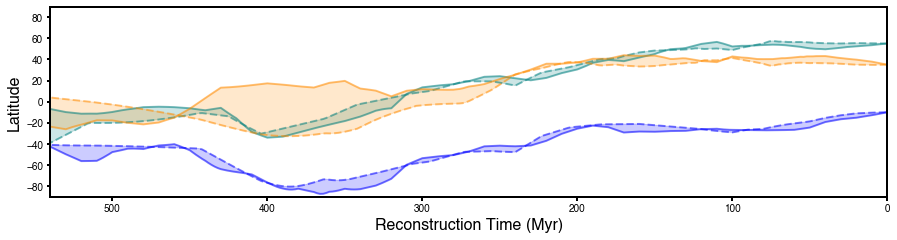

In [8]:
import numpy as np
from gprm import MotionPathFeature

M2021 = Reconstructions.fetch_Merdith2021()
Paleomap = Reconstructions.fetch_Scotese()
TC2017 = Reconstructions.fetch_TorsvikCocks2017()

path_times = np.arange(0.,1001.,2.)

def plot_paths(ax, reconstruction_model, coord, plate_id, color, linestyle, label):
    
    Trails = MotionPathFeature(seed_points=coord, 
                               path_times=path_times, 
                               reconstruction_plate_id=plate_id[0],
                               relative_plate_id=1).reconstruct_motion_path(reconstruction_model)
    ax.plot(path_times[::-1],Trails[0][:,0], color=color, linewidth=2, alpha=0.5, label=label, linestyle=linestyle)
    ax.set_xlim(540,0)
    ax.set_ylim(-90,90)
    ax.grid()
    
    return Trails[0][:,0]


fig, ax = plt.subplots(nrows=1, figsize=(15,3.5))

SeedPointDictionary = {
    'Laurentia': {'SeedPoint':(55,-85), 'PlateID':[101], 'color':'teal'}, 
    'Congo': {'SeedPoint':(-10,22), 'PlateID':[701], 'color':'blue'},
    'Baltica': {'SeedPoint':(55,40), 'PlateID':[302], 'color':'mediumturquoise'},
    'Australia': {'SeedPoint':(-25,130), 'PlateID':[801], 'color':'darkgreen'},
    'Siberia': {'SeedPoint':(63,110), 'PlateID':[401], 'color':'dimgray'},
    'North China': {'SeedPoint':(35,122), 'PlateID':[601], 'color':'darkorange'},
    'South China': {'SeedPoint':(35,122), 'PlateID':[602], 'color':'crimson'},
}
                       

for block in ['Laurentia', 'Congo', 'North China']:
    trails_for_all_models = []
    for (reconstruction_model, linestyle) in zip([TC2017, Paleomap], ['-', '--']):
        trails = plot_paths(ax, 
                            reconstruction_model, 
                            SeedPointDictionary[block]['SeedPoint'],
                            SeedPointDictionary[block]['PlateID'],
                            SeedPointDictionary[block]['color'],
                            linestyle,
                            block)
        
        trails_for_all_models.append(trails)
        
    latitude_range = np.vstack(trails_for_all_models)
    
    plt.fill_between(path_times[::-1],latitude_range.min(axis=0), latitude_range.max(axis=0), 
                     color=SeedPointDictionary[block]['color'], alpha=0.2)


plt.xlabel('Reconstruction Time (Myr)', fontsize=16)
plt.ylabel('Latitude', fontsize=16)


In [10]:
import glob
import geopandas as gpd
from gprm.utils.create_gpml import gpml2gdf
from gprm.utils.spatial import polygon_zonal_areas

file_list = glob.glob('/Users/simon/Data/GPlates/PublishedModels/Scotese_PaleoAtlas/kocsis/CS/*Ma_CS_v7.shp')

time_list = []  #.append(file_name.split('_')[-1][:-5])
for file_name in file_list:
    time_list.append(file_name.split('/')[-1].split('Ma')[0])
    
# need to sort the time slices into order so that we can proceed from oldest to youngest
reconstruction_times = [np.float64(reconstruction_time) for reconstruction_time in time_list]
ind = np.argsort(reconstruction_times)[::-1]
time_list = [time_list[indx] for indx in ind]
reconstruction_times = [reconstruction_times[indx] for indx in ind]


binsize = 2
bin_edges = np.arange(-90.,90.+binsize,binsize)
lats = np.arange(-90.,90.+1,1)

cm_time_series = []
cs_time_series = []

for reconstruction_time in reconstruction_times:
    
    pygplates.reconstruct('/Users/simon/Data/GPlates/PublishedModels/Scotese_PaleoAtlas/kocsis/CM_cat.gpml', 
                          [], './tmp.shp', reconstruction_time)
    gdf = gpd.read_file('./tmp.shp')
    
    result_cm = polygon_zonal_areas(gdf, method='rasterize',binsize=binsize)
    
    pygplates.reconstruct('/Users/simon/Data/GPlates/PublishedModels/Scotese_PaleoAtlas/kocsis/CS_cat.gpml', 
                          [], './tmp.shp', reconstruction_time)
    gdf = gpd.read_file('./tmp.shp')
    
    result_cs = polygon_zonal_areas(gdf, method='rasterize',binsize=binsize)
    
    cm_time_series.append(result_cm)
    cs_time_series.append(result_cs)
    

OGR Writer: Mismatch in field types.
Layer type:  4
Model type:  0
OGR Writer: Mismatch in field types.
Layer type:  4
Model type:  0
OGR Writer: Mismatch in field types.
Layer type:  4
Model type:  0
OGR Writer: Mismatch in field types.
Layer type:  4
Model type:  0
OGR Writer: Mismatch in field types.
Layer type:  4
Model type:  0
OGR Writer: Mismatch in field types.
Layer type:  4
Model type:  0
OGR Writer: Mismatch in field types.
Layer type:  4
Model type:  0
OGR Writer: Mismatch in field types.
Layer type:  4
Model type:  0
OGR Writer: Mismatch in field types.
Layer type:  4
Model type:  0
OGR Writer: Mismatch in field types.
Layer type:  4
Model type:  0
OGR Writer: Mismatch in field types.
Layer type:  4
Model type:  0
OGR Writer: Mismatch in field types.
Layer type:  4
Model type:  0
OGR Writer: Mismatch in field types.
Layer type:  4
Model type:  0
OGR Writer: Mismatch in field types.
Layer type:  4
Model type:  0
OGR Writer: Mismatch in field types.
Layer type:  4
Model type

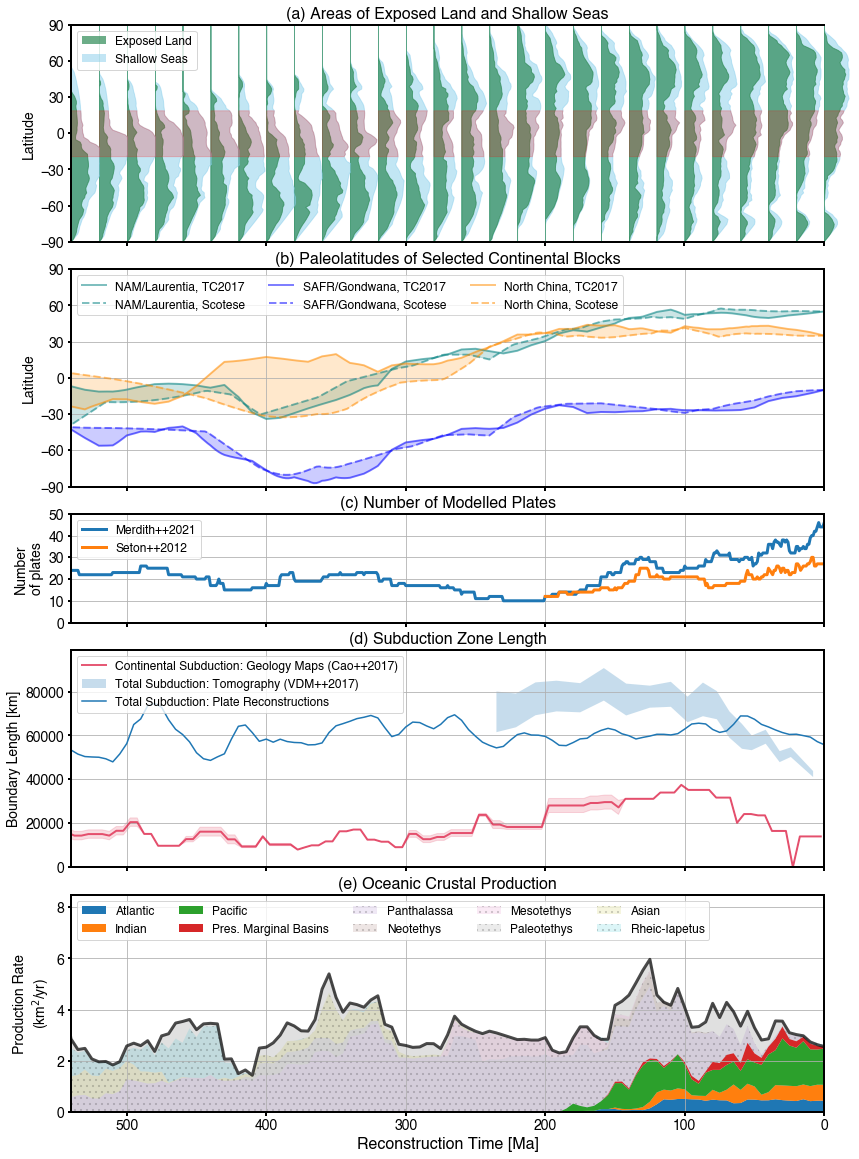

In [13]:
from matplotlib.patches import Patch

plot_time_max = 540.
ylabel_fontsize = 14
title_fontsize = 16
legend_fontsize = 12
tick_fontsize = 14

bin_centers = (bin_edges[:-1]+bin_edges[1:])/2.
time_array = np.arange(0,541,20)

fig = plt.figure(figsize=(14,20))
gs = fig.add_gridspec(nrows=5, ncols=len(time_array), height_ratios = [1,1,0.5,1,1], wspace=0.2, hspace=.14)


###############################################
#ax = fig.add_subplot(gs[0:10, :])

stride = 2

#gs = fig.add_gridspec(nrows=1, ncols=len(time_array))

i = 0
ax_objs = []

for i, reconstruction_time in enumerate(time_array):
    
    tindex = np.where(reconstruction_times==reconstruction_time)[0]
          
    if tindex.size==0:
        tindex = np.where(reconstruction_times==reconstruction_time-5)[0]
    if tindex.size==0:
        tindex = np.where(reconstruction_times==reconstruction_time+5)[0]
                
    x = np.array(cm_time_series[int(tindex)])
    x2 = np.array(cs_time_series[int(tindex)])
    x_d = bin_centers

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[0, 
                                      len(time_array)-i-1:len(time_array)-i]))

    # plotting the distribution
    tropical_zone_ind = np.logical_and(x_d>-20,x_d<20)
    ax_objs[-1].fill_betweenx(x_d, x, alpha=0.5, color='skyblue')
    ax_objs[-1].fill_betweenx(x_d, x2, alpha=0.7, color='seagreen')
    ax_objs[-1].fill_betweenx(x_d[tropical_zone_ind], x[tropical_zone_ind], alpha=0.2, color='red')

    # setting uniform x and y lims
    ax_objs[-1].set_ylim(-90,90)
    ax_objs[-1].set_xlim(0,4500000)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_xticklabels([])
    ax_objs[-1].set_yticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)
        ax_objs[-1].set_xticks([])
        ax_objs[-1].set_yticks([])
        
gs.update(wspace=-0.02)

t0_axes_bbox = ax_objs[0].get_position()
tmax_axes_bbox = ax_objs[-1].get_position()

ax_objs.append(fig.add_axes([tmax_axes_bbox.x0, tmax_axes_bbox.y0, t0_axes_bbox.x0-tmax_axes_bbox.x0, t0_axes_bbox.y1-tmax_axes_bbox.y0]))

ax_objs[-1].set_ylim(-90,90)
ax_objs[-1].set_xlim(540,0)

ax_objs[-1].patch.set_alpha(0)

spines = ["right"]
for s in spines:
    ax_objs[-1].spines[s].set_visible(False)
ax_objs[-1].set_xticks(np.arange(0,541,100))

ax_objs[-1].set_ylabel("Latitude", fontsize=ylabel_fontsize)

ax_objs[-1].set_xticklabels([])
ax_objs[-1].set_yticks(np.arange(-90,91,30))
ax_objs[-1].set_title('(a) Areas of Exposed Land and Shallow Seas', fontsize=title_fontsize)

legend_elements = [Patch(facecolor='seagreen', alpha=0.7,
                         label='Exposed Land'),
                   Patch(facecolor='skyblue', alpha=0.5,
                         label='Shallow Seas')]
ax_objs[-1].legend(handles=legend_elements, loc='upper left', fontsize=legend_fontsize)
ax_objs[-1].tick_params(axis='both', which='major', labelsize=tick_fontsize)


###############################################
ax = fig.add_subplot(gs[1, :-1])
for block in ['Laurentia', 'Congo', 'North China']:
    trails_for_all_models = []
    for (reconstruction_model, linestyle) in zip([TC2017, Paleomap], ['-', '--']):
        trails = plot_paths(ax, 
                            reconstruction_model, 
                            SeedPointDictionary[block]['SeedPoint'],
                            SeedPointDictionary[block]['PlateID'],
                            SeedPointDictionary[block]['color'],
                            linestyle,
                            block)
        
        trails_for_all_models.append(trails)
        
    latitude_range = np.vstack(trails_for_all_models)
    
    ax.fill_between(path_times[::-1],latitude_range.min(axis=0), latitude_range.max(axis=0), 
                     color=SeedPointDictionary[block]['color'], alpha=0.2, label='_nolegend_')

ax.legend(labels=['NAM/Laurentia, TC2017', 'NAM/Laurentia, Scotese',
                  'SAFR/Gondwana, TC2017', 'SAFR/Gondwana, Scotese',
                  'North China, TC2017', 'North China, Scotese'], 
          loc='upper left', ncol=3, fontsize=legend_fontsize)
ax.set_ylabel('Latitude', fontsize=ylabel_fontsize)
ax.grid()
ax.set_xticklabels([])
ax.set_yticks(np.arange(-90,91,30))
ax.set_title('(b) Paleolatitudes of Selected Continental Blocks', fontsize=title_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)


###############################################   
ax = fig.add_subplot(gs[2, :-1])
ax.plot(M2021_time_series, M2021_nplates, label='Merdith++2021', linewidth=3)
ax.plot(S2012_time_series, S2012_nplates, label='Seton++2012', linewidth=3)
ax.set_ylabel('Number\nof plates', fontsize=ylabel_fontsize)
ax.grid()
ax.legend(fontsize=legend_fontsize)
ax.set_xlim(plot_time_max,0)
ax.set_xticklabels([])
ax.set_yticks(np.arange(0,51,10))
ax.set_title('(c) Number of Modelled Plates', fontsize=title_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)


###############################################
ax = fig.add_subplot(gs[3, :-1])
ax.plot(ctime_bins, summed_length_av, linewidth=2, color='crimson', alpha=0.7, label='Continental Subduction: Geology Maps (Cao++2017)')
ax.fill_between(vdm.time, vdm.length-vdm['length error'], vdm.length+vdm['length error']+vdm['imaging error'],alpha=0.25, label='Total Subduction: Tomography (VDM++2017)')
ax.plot(plot_time_series,
           uniform_filter1d(no_collision_arc_lengths, size=3), label='Total Subduction: Plate Reconstructions')

ax.fill_between(ctime_bins, summed_length_min, summed_length_max,color='crimson',alpha=0.15)

ax.set_ylim(0,99000)
ax.set_xlim(plot_time_max,0)
ax.set_ylabel('Boundary Length [km]', fontsize=ylabel_fontsize)
ax.grid()
ax.legend(loc='upper left', fontsize=legend_fontsize)
ax.set_xticklabels([])
ax.set_title('(d) Subduction Zone Length', fontsize=title_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)


###############################################
ax = fig.add_subplot(gs[4, :-1])
ax.plot(np.arange(min_time, max_time + time_step, time_step), global_crustal_production, color='black',linewidth=3,alpha=0.7)

ax.fill_between(np.arange(min_time, max_time + time_step, time_step), global_crustal_production, color='lightgrey', alpha=0.7)

stacks = ax.stackplot(np.arange(min_time, max_time + time_step, time_step), 
                       np.vstack((atlantic_crustal_production, 
                                  indian_crustal_production, 
                                  pacific_crustal_production, 
                                  other_crustal_production_preserved,
                                  panthalassa_crustal_production,
                                  tethys3_crustal_production,
                                  tethys2_crustal_production,
                                  tethys_crustal_production,
                                  asian_crustal_production,
                                  rheic_crustal_production)),
                      labels=['Atlantic', 'Indian', 'Pacific', 'Pres. Marginal Basins', 'Panthalassa','Neotethys','Mesotethys','Paleotethys','Asian','Rheic-Iapetus'])

#hatches=["\\", "//","+"]
for stack in stacks[4:]:
    stack.set_hatch('..')
    #stacks[3].set_edgecolor('red')
    #stack.set_facecolor('white')
    stack.set_alpha(0.15)
    stack.set_edgecolor('black')
    stack.set_linewidth(0)

#tmp = stacks[3]
#np.vstack((atlantic_crustal_production, indian_crustal_production, pacific_crustal_production))
ax.set_ylim(0,8.5)
ax.set_xlim(plot_time_max,0)
ax.set_xlabel('Reconstruction Time [Ma]', fontsize=16)
ax.set_ylabel('Production Rate\n(km$^2$/yr)', fontsize=ylabel_fontsize)
ax.legend(loc='upper left', ncol=5, fontsize=legend_fontsize)
ax.grid()
ax.set_title('(e) Oceanic Crustal Production', fontsize=title_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.savefig('./Figure6.pdf')
plt.show()
